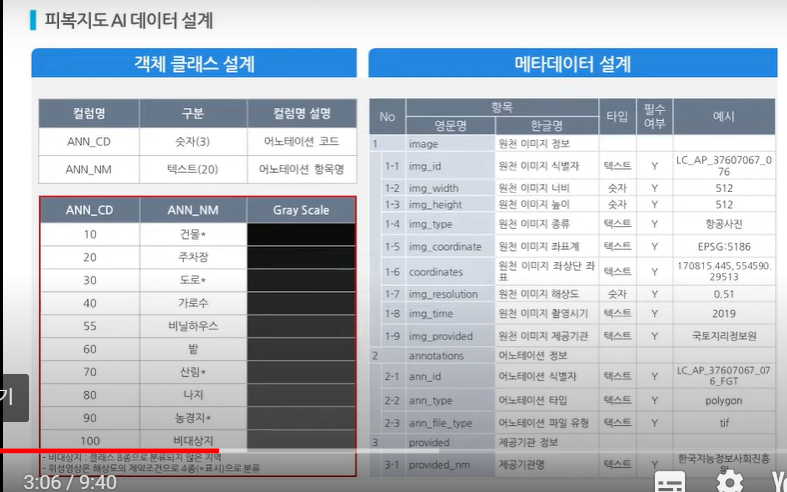

https://www.kaggle.com/code/freewinner13579/2-5d-train/edit

https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=&topMenu=&aihubDataSe=data&dataSetSn=643


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import cv2
from tqdm.notebook import tqdm
import tifffile as tiff
import json
import pyproj
from PIL import Image,ImageDraw
import json

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import sys
import shutil
import pandas as pd

from torch.utils.data import Dataset
import xml.etree.ElementTree as et
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn


import time
from matplotlib.patches import Rectangle
import segmentation_models_pytorch as smp
from torch.cuda import amp
from collections import defaultdict
import copy
import random



import albumentations as A # optimizer https://hoya012.github.io/blog/albumentation_tutorial/

# 25cm, 0.25m 는 25*25 사이즈의 크기가 점으로 표현 가능한 해상도를 뜻함함
# tiff 데이터는 np.array 로 넘파이화 시키면 될듯

c:\Users\LG\anaconda3\envs\sw_acp\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
""" import math
from PIL import Image, ImageDraw 
from PIL import ImagePath  
side = 8
xy = [ 
    ((math.cos(th) + 1) * 90, 
     (math.sin(th) + 1) * 60) 
    for th in [i * (2 * math.pi) / side for i in range(side)] 
    ]  
xy.append(xy[0])
  
  
print(xy)


image = ImagePath.Path(xy).getbbox()   
size = list(map(int, map(math.ceil, image[2:]))) 
  
img = Image.new("RGB", size)  
img1 = ImageDraw.Draw(img)   
img1.polygon(xy, fill =(255,255,0), outline ="blue")  
  
img.show()  """

' import math\nfrom PIL import Image, ImageDraw \nfrom PIL import ImagePath  \nside = 8\nxy = [ \n    ((math.cos(th) + 1) * 90, \n     (math.sin(th) + 1) * 60) \n    for th in [i * (2 * math.pi) / side for i in range(side)] \n    ]  \nxy.append(xy[0])\n  \n  \nprint(xy)\n\n\nimage = ImagePath.Path(xy).getbbox()   \nsize = list(map(int, map(math.ceil, image[2:]))) \n  \nimg = Image.new("RGB", size)  \nimg1 = ImageDraw.Draw(img)   \nimg1.polygon(xy, fill =(255,255,0), outline ="blue")  \n  \nimg.show()  '

In [3]:
path = "C:/Cdrive/Ddrive/study/sw_acp/126.토지 피복지도 항공위성 이미지 데이터(제주도)/01.데이터/"#"F:/sw_ap/126.토지 피복지도 항공위성 이미지 데이터(제주도)/01.데이터/"
mode = "train"
mode = "1.Training/" if (mode=="train") else "2.Validation/"
image_name = "LC_JJ_AP25_33606092_085_2019_FGT_1024"#"LC_JJ_AP25_33606070_001_2019_FGT_1024" 
meta_iamge = "LC_JJ_AP25_33606092_085_2019_FGT_META_1024" #"LC_JJ_AP25_33606070_001_2019_FGT_META_1024" #LC_JJ_AP25_33606067_016_2019_CGT.tif
image_file_name = "항공사진_FGT_1024픽셀"
# path + mode + ("원천데이터" or "라벨링데이터") + image_name
image_path = path + mode + "원천데이터/TS_"+image_file_name+"/" + image_name+".tif"
label_path = path + mode + "라벨링데이터/TL_"+image_file_name+"/"+image_file_name+"_Json/" + image_name+".json"
meta_path = path + mode + "라벨링데이터/TL_"+image_file_name+"/"+image_file_name+"_Meta/" + meta_iamge+".json"
meta_tif_path = path + mode + "라벨링데이터/TL_"+image_file_name+"/"+image_file_name+"_Tif/" + image_name+".tif"

In [4]:
size = 512
train_batch_size = 10
valid_batch_size = train_batch_size*2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
backbone = 'efficientnet-b0'
num_classes = 10
n_accumulate  = max(1, 32//train_batch_size)
lr = 2e-3
min_lr = 1e-6
epochs = 100
scheduler_name = 'CosineAnnealingLR'
T_max = int(30000/train_batch_size*epochs)+50
T_0 = 25
warmup_epochs = 0
wd = 1e-6
exp_name = '2.5D'
comment = 'unet-efficientnet_b0-160x192-ep=5'
model_name = 'Unet'
n_fold = 5
folds = [0]


"""
class CFG:

    exp_name      = '2.5D'
    comment       = 'unet-efficientnet_b0-160x192-ep=5'
    model_name    = 'Unet'

    n_fold        = 5
    folds         = [0]

"""

"\nclass CFG:\n\n    exp_name      = '2.5D'\n    comment       = 'unet-efficientnet_b0-160x192-ep=5'\n    model_name    = 'Unet'\n\n    n_fold        = 5\n    folds         = [0]\n\n"

In [5]:
color ={"건물" : (255,0,0), "주차장":(0,255,0),"비닐하우스":(0,0,255),"나지":(255,255,0)}

In [6]:
img = Image.open("C:/Cdrive/Ddrive/study/sw_acp/126.토지 피복지도 항공위성 이미지 데이터(제주도)/01.데이터/1.Training/원천데이터/TS_항공사진_FGT_512픽셀/LC_JJ_AP25_33606070_001_2019_FGT.tif")
img = np.array(img,"float32")


In [7]:
img.shape

(512, 512, 3)

In [8]:
img

array([[[143., 163., 159.],
        [164., 185., 181.],
        [176., 194., 192.],
        ...,
        [ 81., 128.,  71.],
        [ 81., 126.,  70.],
        [ 75., 121.,  65.]],

       [[130., 152., 146.],
        [162., 182., 176.],
        [173., 191., 189.],
        ...,
        [ 97., 143.,  87.],
        [ 91., 137.,  80.],
        [ 92., 139.,  82.]],

       [[135., 156., 147.],
        [158., 172., 167.],
        [171., 188., 182.],
        ...,
        [ 86., 133.,  77.],
        [ 96., 142.,  86.],
        [104., 147.,  96.]],

       ...,

       [[ 67.,  75.,  60.],
        [ 66.,  74.,  58.],
        [ 79.,  90.,  78.],
        ...,
        [198., 193., 174.],
        [197., 192., 173.],
        [173., 165., 141.]],

       [[ 76.,  88.,  69.],
        [ 66.,  73.,  60.],
        [ 76.,  83.,  75.],
        ...,
        [138., 133., 103.],
        [113., 112.,  76.],
        [ 89.,  92.,  55.]],

       [[ 68.,  80.,  67.],
        [ 67.,  76.,  66.],
        [ 74.,  

In [9]:
class image_annotation():
    def __init__(self,path="C:/Cdrive/Ddrive/study/sw_acp/126.토지 피복지도 항공위성 이미지 데이터(제주도)/01.데이터/",
                 mode="train",
                 name = "LC_JJ_AP25_33606092_085_2019_FGT",
                 image_file="항공사진_FGT",size=1024):
        
        self.path = path
        
        mode = "1.Training/" if (mode=="train") else "2.Validation/"
        self.mode = mode
        
        self.size = size
        ad = "_1024" if size==1024 else ""
        ad_file = "_1024픽셀" if size==1024 else "_512픽셀"
        self.name = {"image":name+ad,"meta":name+"_META"+ad,"image_file" : image_file+ad_file}
        
        self.image_path = self.path + self.mode + "원천데이터/TS_" + self.name["image_file"] + "/" + self.name["image"] + ".tif"
        self.label_path = self.path + self.mode + "라벨링데이터/TL_" + self.name["image_file"] + "/" + self.name["image_file"] + "_Json/" + self.name["image"] + ".json"
        self.meta_path = self.path + self.mode + "라벨링데이터/TL_" + self.name["image_file"] + "/" + self.name["image_file"] +"_Meta/" + self.name["meta"] + ".json"
        self.meta_tif_path = self.path + self.mode + "라벨링데이터/TL_" + self.name["image_file"] + "/" + self.name["image_file"] +"_Tif/" + self.name["image"] + ".tif"
        
        self.Image = tiff.imread(self.image_path)
        self.img_w,self.img_h,self.img_c = self.Image.shape
        self.img_shape = (self.img_w,self.img_h,self.img_c)
        
        try:
            with open(self.meta_path,"r",encoding='cp949') as f:
                meta_data = json.load(f)
        except:
            with open(self.meta_path,"r") as f:
                meta_data = json.load(f)
                
        self.Meta = meta_data[0]
        self.magnification = 1/self.Meta['img_resolution'] # 배율
                
        try:
            with open(self.label_path,"r") as f:
                self.label_data = json.load(f)
        except:
            with open(self.label_path,"r",encoding='cp949') as f:
                self.label_data = json.load(f)
                
                
        self.leftup_pos = self.Meta['coordinates'].split(", ")
        self.leftup_pos=[float(self.leftup_pos[i]) for i in range(len(self.leftup_pos))]
                
                
                
    def meta_draw(self):
        img = Image.open(self.meta_tif_path).convert('RGB')
        plt.imshow(img)
    
    def draw(self):
        
        img = Image.open(self.image_path).convert('RGB')
        draw = ImageDraw.Draw(img)
        for i in range(len(self.label_data['features'])):
            _color = (random.randint(0,200),random.randint(0,200),random.randint(0,200))
            ann_nm=self.label_data['features'][i]['properties']['ANN_NM']
            if True:#(ann_nm in list(color)):
                coordinates = np.array(self.label_data['features'][i]['geometry']['coordinates'][0])
                shape_list=list(coordinates.shape)
                for j in range(len(shape_list)):
                    if shape_list[j]!=1:
                        break
                    coordinates = copy.deepcopy(coordinates[0])
                    
                
                coordinates[:,0]-=self.leftup_pos[0]
                coordinates[:,1]-=self.leftup_pos[1] # 상대 위치 계산
                coordinates[:,1]*=(-1)
                lt=coordinates.tolist()
                
                lt = [(lt[j][0]*self.magnification,lt[j][1]*self.magnification)for j in range(len(lt))]
                if ann_nm in list(color):
                    draw.polygon(lt,width = 3, fill = _color, outline=_color)
                    #draw.polygon(lt,width = 3, outline=(255,255,255))
                else:
                    if ann_nm!="비대상지":
                        draw.polygon(lt,width = 3, fill = _color, outline=_color)
                    #else:
                        #draw.polygon(lt,width=3, fill=(255,255,255),outline=(255,255,255))
                    #draw.polygon(lt,width = 3, outline=(255,255,255))
                    
        plt.imshow(img)
        
        
    def list_coordinates_cnt(self,coordinates):
        if not isinstance(coordinates,list):
            return 0
        
        return self.list_coordinates_cnt(coordinates=coordinates[0])+1
    
    def list_coordinates(self,coordinates,cnt,i=0):
        if i==cnt:
            self.stack.append(coordinates)
            return
        
        for j in range(len(coordinates)):
            self.list_coordinates(coordinates=coordinates[j],cnt=cnt,i=i+1)
        
                
        
        
        
    def coordinates2json(self):
        
        result = {'name':self.label_data['name'].split("_1024")[0],
                  'features':[]}
        
        """
        features : [{ann_nm : '건물',coordinates:[[]]}]
        """
        
        
        for i in range(len(self.label_data['features'])):
            ann_nm=self.label_data['features'][i]['properties']['ANN_NM']
            feature={"ann_nm":ann_nm,"coordinates":[]}
            try:
                coordinates = np.array(self.label_data['features'][i]['geometry']['coordinates'][0])
                shape_list=list(coordinates.shape)
                for j in range(len(shape_list)):
                    if shape_list[j]!=1:
                        break
                    coordinates = copy.deepcopy(coordinates[0])
                    
                    
                coordinates[:,0]-=self.leftup_pos[0]
                coordinates[:,1]-=self.leftup_pos[1] # 상대 위치 계산
                coordinates[:,1]*=(-1)
                lt=coordinates.tolist()
                
                for j in range(len(lt)):
                    feature['coordinates'].append((lt[j][0]*self.magnification,lt[j][1]*self.magnification))
                    
                result['features'].append(feature)
                
                """ if ann_nm=="비대상지":
                    print("!")
                    print(np.array(self.label_data['features'][i]['geometry']['coordinates'][0]))
                    print(np.array(self.label_data['features'][i]['geometry']['coordinates'][0]).shape)
                    print(coordinates)
                    print(self.leftup_pos)
                    print(feature)
                    print(lt)
                    print(self.magnification) """
                    
            
            except:

                cnt = self.list_coordinates_cnt(self.label_data['features'][i]['geometry']['coordinates'])
                self.stack=[]
                self.list_coordinates(self.label_data['features'][i]['geometry']['coordinates'],cnt-2)
                #print(self.stack)
                for j in range(len(self.stack)):
                    coordinates = np.array(self.stack[j])
                    coordinates[:,0]-=self.leftup_pos[0]
                    coordinates[:,1]-=self.leftup_pos[1]
                    coordinates[:,1]*=(-1)
                    
                    """ for k in range(len(shape_list)):
                        if shape_list[k]!=1:
                            break
                        lt = lt[0] """
                    
                    lt=coordinates.tolist()
                    
                    for k in range(len(lt)):
                        feature['coordinates'].append((lt[k][0]*self.magnification,lt[k][1]*self.magnification))
                        
                    result['features'].append(feature)
                    
                    """ if ann_nm=="비대상지":
                        print("!!")
                        print(self.label_data['features'][i]['geometry']['coordinates'])
                        print(self.stack)
                        print(coordinates)
                        print(self.leftup_pos)
                        print(feature)
                        print(lt)
                        print(self.magnification) """
                    
            
        #print(result)
        return [result]#json.dumps(result,ensure_ascii = False)
    
    def save_image_np(self,save_img_path):
        img = Image.open(self.image_path)#.convert("L")
        img = np.array(img,"float32")
        #print(img)
        img /= 255.0
        #img = np.stack([img for i in range(10)],2) 흑백을 10채널로 변환
        #print(f"image shape : {img.shape}")
        np.save(save_img_path,img)
    
    def save_image(self,img_path,mask_path,name): # , 그리고 옮길때 10 차원으로 numpy 로 만들어서 저장
        # 이미지도 클래스 수만큼 채널이 있어야 함
        #shutil.copyfile(self.image_path ,img_path)
        self.save_image_np(img_path)
        self.save_json(path=mask_path,name = name)
        
    def save_json(self,path,name):
        json_result = self.coordinates2json()
        json_path = path+name+".json"
        try:
            with open(json_path,'w',encoding='cp949') as f:
                json.dump(json_result,f, ensure_ascii=False,indent=4)
                
        except:
            with open(json_path,'w') as f:
                json.dump(json_result,f, ensure_ascii=False,indent=4)
                
                
        self.save_mask_image(path+name+".npy",coordinates = json_result)
        
        
    def save_mask_image(self,path,coordinates):
        #print("json result")
        #print(coordinates)
        classes = {"건물":[],"주차장":[],"비닐하우스":[],"나지":[],"도로":[],"가로수":[],"밭":[],"산림":[],"농경지":[],"비대상지":[]}
        for feature in coordinates[0]["features"]:
            classes[feature["ann_nm"]].append(feature["coordinates"])
            
        result = []
            
        for Class in classes:
            img = Image.new("L",(self.size,self.size))
            draw = ImageDraw.Draw(img)
            if Class!="비대상지":
                for coordinate in classes[Class]:
                    draw.polygon(coordinate,width = 1, fill = 1) # mask 데이터는 최종적으로 1아니면 0의 형태로 만들어야 함
                
                #for coordinate in classes["비대상지"]:
                    #draw.polygon(coordinate, width = 1, fill = 0)
                
            #plt.imshow(img)
	
            img_np = np.array(img)
            #print("before")
            #print(cnt)
            #print(np.max(img_np))
            img_np[img_np!=0]=1
            img_np[img_np==0]=0
            #print(np.max(img_np))
            result.append(img_np)
                
        result = np.stack(result,2)
        #print(f"result shape : {result.shape}")
        #print(f"result : {result}")
        np.save(path,result)
        #print(path+Class+".tiff")
            
            
        
            
             

            
"""
[
    {
        "name": "LC_JJ_AP25_33606070_001_2019_FGT",
        "features": [
            {
                "ann_nm": "도로",
                "coordinates": [
                    [


"""
        
    

    
    
"""{'type': 'FeatureCollection',
 'name': 'LC_JJ_AP25_33606092_085_2019_FGT_1024',
 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:EPSG::5186'}},
 'features': [{'type': 'Feature',
   'properties': {'ANN_CD': 10, 'ANN_NM': '건물', 'ANN_TYPE': 'fine'},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[133398.9649999996, 90479.68550000021],
      [133398.18619999953, 90479.78709999943],
      [133394.7326999975, 90480.02410000062],
      [133389.9247999982, 90480.80279999967],
      [133389.99249999807, 90482.32650000045],
      [133390.3310999985, 90484.08709999919],
      [133399.16809999922, 90482.83429999895],
      [133398.9649999996, 90479.68550000021]]]}},
      """
		

"{'type': 'FeatureCollection',\n 'name': 'LC_JJ_AP25_33606092_085_2019_FGT_1024',\n 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:EPSG::5186'}},\n 'features': [{'type': 'Feature',\n   'properties': {'ANN_CD': 10, 'ANN_NM': '건물', 'ANN_TYPE': 'fine'},\n   'geometry': {'type': 'Polygon',\n    'coordinates': [[[133398.9649999996, 90479.68550000021],\n      [133398.18619999953, 90479.78709999943],\n      [133394.7326999975, 90480.02410000062],\n      [133389.9247999982, 90480.80279999967],\n      [133389.99249999807, 90482.32650000045],\n      [133390.3310999985, 90484.08709999919],\n      [133399.16809999922, 90482.83429999895],\n      [133398.9649999996, 90479.68550000021]]]}},\n      "

In [10]:
"""    def __init__(self,path="C:/Cdrive/Ddrive/study/sw_acp/126.토지 피복지도 항공위성 이미지 데이터(제주도)/01.데이터/",
                 mode="train",
                 name = "LC_JJ_AP25_33606092_085_2019_FGT",
                 image_file="항공사진_FGT",size=1024):"""

'    def __init__(self,path="C:/Cdrive/Ddrive/study/sw_acp/126.토지 피복지도 항공위성 이미지 데이터(제주도)/01.데이터/",\n                 mode="train",\n                 name = "LC_JJ_AP25_33606092_085_2019_FGT",\n                 image_file="항공사진_FGT",size=1024):'

In [11]:
Image_Annotation = image_annotation()#(name = "LC_JJ_AP25_33606067_001_2019_CGT",
                                    #image_file="항공사진_CGT",size=512)

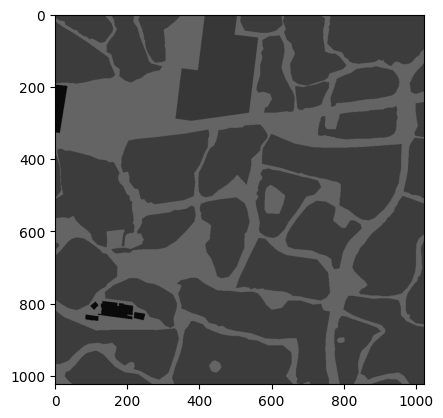

In [12]:
Image_Annotation.meta_draw()

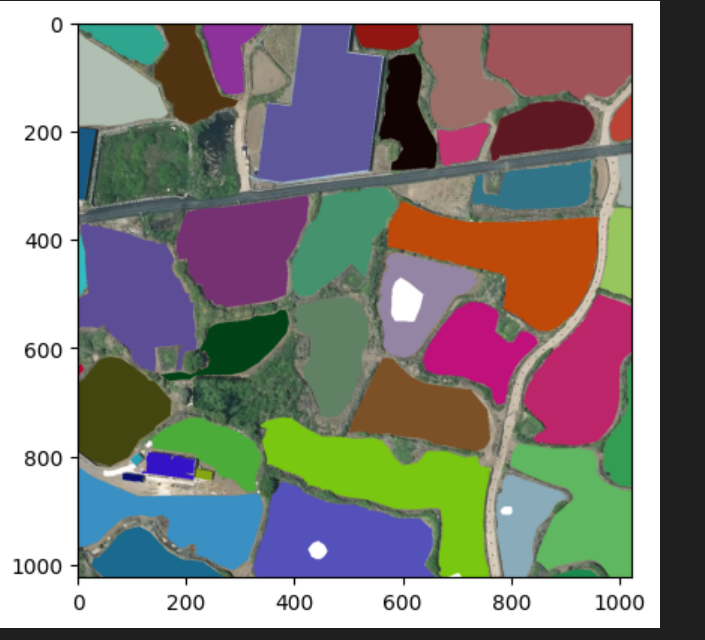

영역 마스킹 할때 비대상지는 nand 적용해서 없애기

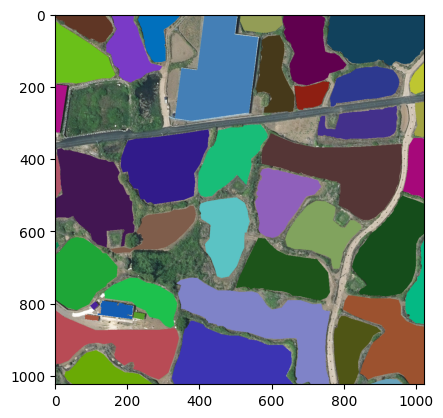

In [13]:
Image_Annotation.draw()

In [14]:
Image_Annotation.coordinates2json()

[{'name': 'LC_JJ_AP25_33606092_085_2019_FGT',
  'features': [{'ann_nm': '건물',
    'coordinates': [(119.35999999835622, 848.7579999991576),
     (116.2447999981232, 848.3516000022646),
     (102.43079998996109, 847.4035999975167),
     (83.1991999928141, 844.288800001319),
     (83.46999999228865, 838.1939999982133),
     (84.82439999398775, 831.1516000032425),
     (120.17239999689627, 836.1628000041819),
     (119.35999999835622, 848.7579999991576)]},
   {'ann_nm': '건물',
    'coordinates': [(244.77119999262504, 846.8619999984512),
     (217.68479999317788, 840.9028000015533),
     (219.30999999435153, 824.109199999366),
     (249.37599999678787, 829.2556000025361),
     (244.77119999262504, 846.8619999984512)]},
   {'ann_nm': '건물',
    'coordinates': [(107.98319999477826, 818.1500000025262),
     (97.01319999212865, 807.3152000020491),
     (111.63999999407679, 795.1264000039082),
     (120.17239999689627, 805.5547999986447),
     (107.98319999477826, 818.1500000025262)]},
   {'ann_nm

In [15]:
"""
 def __init__(self,path="F:/sw_ap/126.토지 피복지도 항공위성 이미지 데이터(제주도)/01.데이터/",
                 mode="train",
                 name = "LC_JJ_AP25_33606092_085_2019_FGT",
       
                 image_file="항공사진_FGT",size=1024):

파일명, meta json 에서 img_id 불러오기(_1024 는 빼기)


train
"F:\sw_ap\126.토지 피복지도 항공위성 이미지 데이터(제주도)\01.데이터\1.Training"

"""

make_dir = "C:/Cdrive/Ddrive/study/sw_acp/refine_data/"
def data_reset():
    
	if os.path.isdir(make_dir):
		shutil.rmtree(make_dir)
		
	os.mkdir(make_dir)
	os.mkdir(make_dir+"512/")
	os.mkdir(make_dir+"1024/")
	os.mkdir(make_dir+"512/mask")
	os.mkdir(make_dir+"512/image")
	os.mkdir(make_dir+"1024/mask")
	os.mkdir(make_dir+"1024/image")    
 
	dir = "C:/Cdrive/Ddrive/study/sw_acp/126.토지 피복지도 항공위성 이미지 데이터(제주도)/01.데이터/1.Training/라벨링데이터/"
	files = os.listdir(dir)
	for file in files:
		if len(file.split("_CGT"))>=2:continue
		print(file)
		print(os.path.isdir(dir+file))
		if os.path.isdir(dir+file):
			
			image_file = "_".join(file.split("_")[1:-1])
			
			label_file = os.listdir(dir+file+"/"+"_".join(file.split("_")[1:])+"_Meta/")
			for label in label_file:
				print(label)
				
				json_path = dir+file+"/"+"_".join(file.split("_")[1:])+"_Meta/"+label
				try:
					with open(json_path,"r",encoding='cp949') as f:
						meta_data = json.load(f)[0]
				except:
					with open(json_path,"r") as f:
						meta_data = json.load(f)[0]
						
				if meta_data["img_width"]==1024:
					name = "_".join(meta_data["img_id"].split("_")[:-1])
					size = 1024
				else:
					name = meta_data["img_id"]
					size = 512
					
					
				Image_Annotation = image_annotation(path=path,
													mode = "train",
													name = name,
													image_file = image_file,
													size = size)
				
				if size==512:
					image_new_path=make_dir+"512/image/"+name+".npy"
					mask_new_path=make_dir+"512/mask/"+name+"/"
				else:
					image_new_path=make_dir+"1024/image/"+name+".npy"
					mask_new_path=make_dir+"1024/mask/"+name+"/"

				os.mkdir(mask_new_path)
					
				Image_Annotation.save_image(img_path = image_new_path, mask_path = mask_new_path,name = name)
				
   
                
 
 

In [16]:
#data_reset() # 데이터 전처리 코드, 시간이 오래걸려서 생략했습니다

https://github.com/qubvel-org/segmentation_models.pytorch

In [17]:
def Make_Datframe(size=512):
    mask_path = make_dir+str(size)+"/mask/"
    image_path = make_dir+str(size)+"/image/"
    mask_list = os.listdir(mask_path)
    image_list = os.listdir(image_path)
    #print(len(json_image_list),len(json_label_list))
    df = [[image_list[i].split(".tiff")[0],image_path+image_list[i],mask_path+mask_list[i]+"/"+mask_list[i]+".npy"] for i in range(len(mask_list))]
    
    print(len(df))
    return pd.DataFrame(df,columns=['name','image_path','mask_path'])
    
    

In [18]:
img = Image.open("C:/Cdrive/Ddrive/study/sw_acp/126.토지 피복지도 항공위성 이미지 데이터(제주도)/01.데이터/1.Training/원천데이터/TS_항공사진_CGT_512픽셀/LC_JJ_AP25_33606067_001_2019_CGT.tif")
img = img.convert("L")


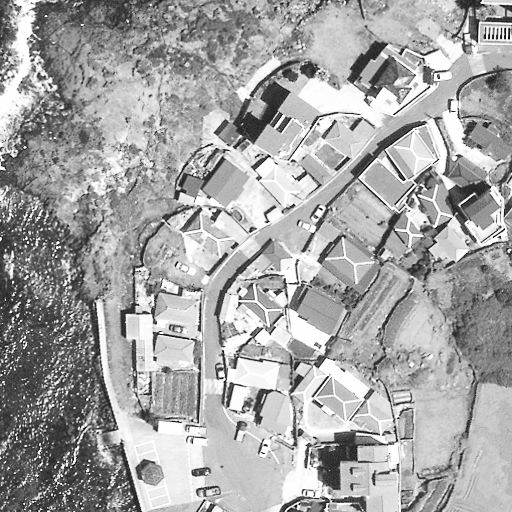

In [19]:
img

In [20]:
img = np.array(img)

In [21]:
img

array([[ 62,  86,  73, ..., 204, 202, 210],
       [ 81,  70,  79, ..., 211, 207, 223],
       [ 58,  72,  92, ..., 212, 212, 216],
       ...,
       [ 77, 157, 117, ..., 197, 193, 196],
       [ 68,  65,  60, ..., 189, 191, 204],
       [ 81,  69,  86, ..., 187, 194, 208]], dtype=uint8)

In [22]:
img.shape

(512, 512)

In [23]:
Q = np.stack([img for i in range(10)],2)

In [24]:
Q

array([[[ 62,  62,  62, ...,  62,  62,  62],
        [ 86,  86,  86, ...,  86,  86,  86],
        [ 73,  73,  73, ...,  73,  73,  73],
        ...,
        [204, 204, 204, ..., 204, 204, 204],
        [202, 202, 202, ..., 202, 202, 202],
        [210, 210, 210, ..., 210, 210, 210]],

       [[ 81,  81,  81, ...,  81,  81,  81],
        [ 70,  70,  70, ...,  70,  70,  70],
        [ 79,  79,  79, ...,  79,  79,  79],
        ...,
        [211, 211, 211, ..., 211, 211, 211],
        [207, 207, 207, ..., 207, 207, 207],
        [223, 223, 223, ..., 223, 223, 223]],

       [[ 58,  58,  58, ...,  58,  58,  58],
        [ 72,  72,  72, ...,  72,  72,  72],
        [ 92,  92,  92, ...,  92,  92,  92],
        ...,
        [212, 212, 212, ..., 212, 212, 212],
        [212, 212, 212, ..., 212, 212, 212],
        [216, 216, 216, ..., 216, 216, 216]],

       ...,

       [[ 77,  77,  77, ...,  77,  77,  77],
        [157, 157, 157, ..., 157, 157, 157],
        [117, 117, 117, ..., 117, 117, 117

In [25]:
Q.shape

(512, 512, 10)

In [26]:
img.shape

(512, 512)

In [27]:
img = Image.open("C:/Cdrive/Ddrive/study/sw_acp/126.토지 피복지도 항공위성 이미지 데이터(제주도)/01.데이터/1.Training/원천데이터/TS_항공사진_CGT_512픽셀/LC_JJ_AP25_33606067_001_2019_CGT.tif")


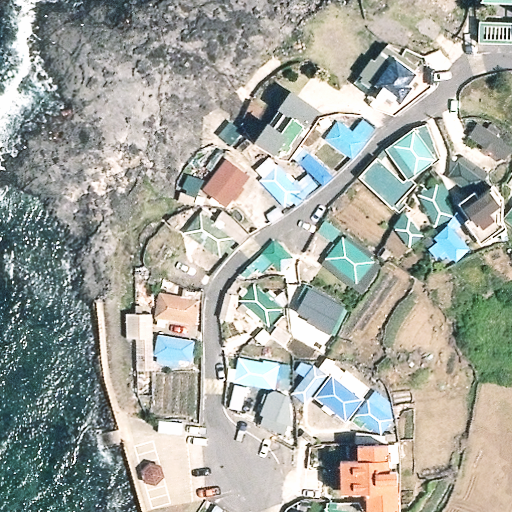

In [28]:
img

In [29]:
img = np.array(img)

In [30]:
img.shape

(512, 512, 3)

In [31]:
img

array([[[ 58,  64,  66],
        [ 80,  88,  92],
        [ 69,  75,  76],
        ...,
        [178, 217, 203],
        [176, 215, 202],
        [188, 221, 209]],

       [[ 74,  83,  89],
        [ 66,  71,  75],
        [ 72,  81,  83],
        ...,
        [182, 225, 213],
        [178, 222, 210],
        [200, 234, 227]],

       [[ 53,  59,  62],
        [ 67,  73,  78],
        [ 84,  95, 100],
        ...,
        [185, 225, 216],
        [183, 226, 215],
        [190, 228, 220]],

       ...,

       [[ 60,  85,  84],
        [130, 168, 175],
        [ 86, 130, 135],
        ...,
        [215, 193, 171],
        [213, 188, 169],
        [215, 191, 171]],

       [[ 46,  78,  75],
        [ 41,  75,  73],
        [ 39,  69,  67],
        ...,
        [209, 184, 158],
        [211, 186, 166],
        [222, 199, 181]],

       [[ 54,  93,  94],
        [ 45,  80,  78],
        [ 56,  98, 101],
        ...,
        [208, 182, 157],
        [214, 189, 167],
        [225, 204, 186]]

In [32]:
df = Make_Datframe()

3280


In [33]:
df

,name,image_path,mask_path
0,LC_JJ_AP25_33606070_001_2019_FGT.npy,C:/Cdrive/Ddrive/study/sw_acp/refine_data/512/...,C:/Cdrive/Ddrive/study/sw_acp/refine_data/512/...
1,LC_JJ_AP25_33606070_002_2019_FGT.npy,C:/Cdrive/Ddrive/study/sw_acp/refine_data/512/...,C:/Cdrive/Ddrive/study/sw_acp/refine_data/512/...
2,LC_JJ_AP25_33606070_003_2019_FGT.npy,C:/Cdrive/Ddrive/study/sw_acp/refine_data/512/...,C:/Cdrive/Ddrive/study/sw_acp/refine_data/512/...
3,LC_JJ_AP25_33606070_004_2019_FGT.npy,C:/Cdrive/Ddrive/study/sw_acp/refine_data/512/...,C:/Cdrive/Ddrive/study/sw_acp/refine_data/512/...
4,LC_JJ_AP25_33606070_005_2019_FGT.npy,C:/Cdrive/Ddrive/study/sw_acp/refine_data/512/...,C:/Cdrive/Ddrive/study/sw_acp/refine_data/512/...
...,...,...,...
3275,LC_JJ_AP25_33608053_027_2019_FGT.npy,C:/Cdrive/Ddrive/study/sw_acp/refine_data/512/...,C:/Cdrive/Ddrive/study/sw_acp/refine_data/512/...
3276,LC_JJ_AP25_33608053_028_2019_FGT.npy,C:/Cdrive/Ddrive/study/sw_acp/refine_data/512/...,C:/Cdrive/Ddrive/study/sw_acp/refine_data/512/...
3277,LC_JJ_AP25_33608053_029_2019_FGT.npy,C:/Cdrive/Ddrive/study/sw_acp/refine_data/512/...,C:/Cdrive/Ddrive/study/sw_acp/refine_data/512/...
3278,LC_JJ_AP25_33608053_031_2019_FGT.npy,C:/Cdrive/Ddrive/study/sw_acp/refine_data/512/...,C:/Cdrive/Ddrive/study/sw_acp/refine_data/512/...


In [34]:
df.iloc[0].image_path

'C:/Cdrive/Ddrive/study/sw_acp/refine_data/512/image/LC_JJ_AP25_33606070_001_2019_FGT.npy'

In [35]:
df.shape

(3280, 3)

In [36]:
df.iloc[0].image_path

'C:/Cdrive/Ddrive/study/sw_acp/refine_data/512/image/LC_JJ_AP25_33606070_001_2019_FGT.npy'

In [37]:
"""
[
    {
        "name": "LC_JJ_AP25_33606070_004_2019_FGT",
        "features": [{"ann_nm":name}]
    }
]

"""

'\n[\n    {\n        "name": "LC_JJ_AP25_33606070_004_2019_FGT",\n        "features": [{"ann_nm":name}]\n    }\n]\n\n'

In [38]:
""" img = Image.open(df.iloc[0].image_path)
mask = Image.open(df.iloc[0].mask_path)
img = np.array(img)
mask = np.array(mask) """

' img = Image.open(df.iloc[0].image_path)\nmask = Image.open(df.iloc[0].mask_path)\nimg = np.array(img)\nmask = np.array(mask) '

In [39]:
""" mask = Image.open("F:/sw_ap/126.토지 피복지도 항공위성 이미지 데이터(제주도)/01.데이터/1.Training/라벨링데이터/TL_항공사진_FGT_512픽셀/항공사진_FGT_512픽셀_Tif/LC_JJ_AP25_33606070_003_2019_FGT.tif")
mask = np.array(mask) """

' mask = Image.open("F:/sw_ap/126.토지 피복지도 항공위성 이미지 데이터(제주도)/01.데이터/1.Training/라벨링데이터/TL_항공사진_FGT_512픽셀/항공사진_FGT_512픽셀_Tif/LC_JJ_AP25_33606070_003_2019_FGT.tif")\nmask = np.array(mask) '

In [40]:
""" img """

' img '

In [41]:
#mask

In [42]:
def rgb2gray(mask):
    pad_mask = np.pad(mask, pad_width=[(0,0),(0,0),(1,0)])
    gray_mask = pad_mask.argmax(-1)
    return gray_mask

In [43]:
#mask = rgb2gray(mask)

In [44]:
#img.shape

In [45]:
#mask.shape

In [46]:
#mask = np.expand_dims(mask, axis=2)

In [47]:
#mask.shape

In [48]:
class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    
    def __len__(self):
        return self.df.shape[0]
    
    
    def preprocess(self,img):
        img_np=np.array(img)
        if len(img_np.shape) == 2:
            img_np = np.expand_dims(img_np, axis=2)

        # HWC to CHW
        img_trans = img_np.transpose((2, 0, 1))
        if img_trans.max() > 1:
            img_trans = img_trans / 255

        return img_trans
    
    def __getitem__(self, index):
        
        image_path = self.df.iloc[index].image_path
        mask_path = self.df.iloc[index].mask_path
        
        img = np.load(image_path)
        
        img = img.astype('float32')
        mx = np.max(img)
        if mx:
            img/=mx
        
        mask = np.load(mask_path)
        mask = mask.astype('float32')
        
        #mask/=255.0
        
        
        if self.transform:
            data = self.transform(image=img,mask=mask)
            img = data['image']
            mask = data['mask']
        
        
        
        
        #img = self.preprocess(img)
        #mask = self.preprocess(mask)
        
        #(512,512,10) -> (10,512,512)
        
        img = np.transpose(img,(2, 0, 1)) # shape 의 0,1,2번째를 순서를 바꿈
        mask = np.transpose(mask,(2, 0, 1))
        
        #img = img[:3]
        #print(f"img shape : {img.shape}")
        
    
        img = torch.tensor(img)
        mask = torch.tensor(mask)
        
        #print(f"img type : {type(img)}, mask type : {type(mask)}")
  
                
            
        return img,mask
 
        

In [49]:
data_transforms = {
    "train": A.Compose([
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=None, p=1.0)
        ], p=0.25),
        A.CoarseDropout(max_holes=8, max_height=size//20, max_width=size//20,
                         min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        ], p=1.0),
    
    "valid": A.Compose([], p=1.0)
}

In [50]:
image_path = df.iloc[100].image_path
mask_path = df.iloc[100].mask_path

img = np.load(image_path)
print(type(img))
img = img.astype('float32')
print(type(img))
mx = np.max(img)
if mx:
	img/=mx
mask = np.load(mask_path)
mask = mask.astype('float32')
mask/=255.0

print(f"img shape : {img.shape}, mask shape : {mask.shape}")


data = data_transforms['train'](image=img,mask=mask)
img = data['image']
mask = data['mask']

# numpy : (높이,너비,채널) || pythorch : (채널, 높이, 너)

img = np.transpose(img,(2, 0, 1))
mask = np.transpose(mask,(2, 0, 1))


img = torch.tensor(img)
mask = torch.tensor(mask)

print(f"img type : {type(img)}, mask type : {type(mask)}")


# RGB 까지 있는 데이터이니까 (batch, 채널 , 높이, 너비, 3) 이런식으로 들어가 있어야할 거같음 이미지도 채널이 있어야 했다. (채널은 10)
# 데이터를 mask 만 사용?
# 마스크 데이터는 2차원, 

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
img shape : (512, 512, 3), mask shape : (512, 512, 10)
img type : <class 'torch.Tensor'>, mask type : <class 'torch.Tensor'>


In [51]:
def prepare_loaders(df):
    shape = df.shape[0]
    train_df = df[:shape*7//10]
    valid_df = df[shape*7//10:]
    
        
    #print(len(train_df))
    #print(len(valid_df))
    #print(train_df)
    #print(valid_df)
    train_dataset = CustomDataset(train_df, transform=data_transforms['train'])
    valid_dataset = CustomDataset(valid_df, transform=data_transforms['valid'])
    #print(len(train_dataset))
    #print(len(valid_dataset))

    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, 
                              num_workers=0, shuffle=True, pin_memory=True, drop_last=False)
    valid_loader = DataLoader(valid_dataset, batch_size=valid_batch_size, 
                              num_workers=0, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader 

In [52]:
train_loader, valid_loader = prepare_loaders(df)
print(len(train_loader),len(valid_loader))

230 50


In [53]:
train_loader

In [54]:
iter(train_loader)

In [55]:
next(iter(train_loader))[1].numpy()

array([[[[0., 0., 0., ..., 1., 1., 1.],
         [0., 0., 0., ..., 1., 1., 1.],
         [0., 0., 0., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

In [56]:
next(iter(train_loader))[1].numpy().shape

(10, 10, 512, 512)

In [57]:
next(iter(train_loader))[1][0][8][0].numpy()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [58]:
next(iter(train_loader))[0].shape

torch.Size([10, 3, 512, 512])

In [59]:
img = next(iter(train_loader))[0][0][0].numpy()


In [60]:
img.shape

(512, 512)

In [61]:
img*255

array([[166.65355 , 161.63385 , 163.64172 , ...,  76.29922 ,  82.32284 ,
         96.37795 ],
       [167.65749 , 165.64961 , 173.6811  , ...,  88.34646 ,  88.34646 ,
        102.40158 ],
       [177.69685 , 173.6811  , 169.66536 , ..., 101.397644, 102.40158 ,
        111.43701 ],
       ...,
       [103.40552 , 113.44488 , 120.47244 , ..., 163.64172 , 173.6811  ,
        166.65355 ],
       [ 96.37795 , 114.448814, 121.47638 , ..., 171.67323 , 168.66142 ,
        167.65749 ],
       [108.4252  , 113.44488 , 106.41733 , ..., 159.62598 , 170.6693  ,
        166.65355 ]], dtype=float32)

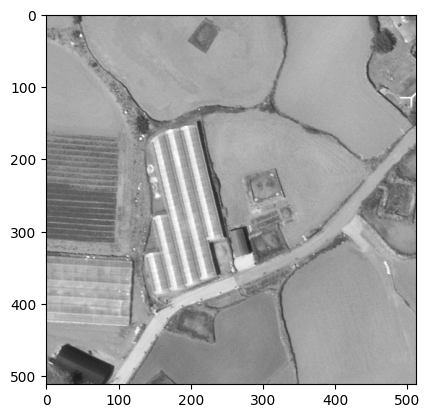

In [62]:
img_2 = Image.fromarray(img*255) # NumPy array to PIL image
plt.imshow(img_2)

In [63]:
imgs, msks = next(iter(train_loader))
imgs.size(), msks.size()

(torch.Size([10, 3, 512, 512]), torch.Size([10, 10, 512, 512]))

In [64]:

def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#     img = clahe.apply(img)
#     plt.figure(figsize=(10,10))
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = ["Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

In [65]:
def plot_batch(imgs, msks, size=3): # 예제는 클래스가 3개라 이걸 RGB 로 체크 
    plt.figure(figsize=(5*5, 5))
    for idx in range(size):
        plt.subplot(1, 5, idx+1)
        img = imgs[idx,].permute((1, 2, 0)).numpy()*255.0
        img = img.astype('uint8')
        msk = msks[idx,].permute((1, 2, 0)).numpy()*255.0
        show_img(img, msk)
    plt.tight_layout()
    plt.show()

In [66]:
#plot_batch(imgs, msks, size=5)

In [67]:
import gc
gc.collect()

3606

In [68]:
import segmentation_models_pytorch as smp
# 기본적으로 있는 모드

def build_model():
    model = smp.Unet(
        encoder_name=backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3, #5로 바꿀수있는지 해보기                 # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=num_classes,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to(device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [69]:
JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
DiceLoss    = smp.losses.DiceLoss(mode='multilabel')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0)) #정확도 계
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

def criterion(y_pred, y_true):
    return 0.5*BCELoss(y_pred, y_true) + 0.5*TverskyLoss(y_pred, y_true)

In [70]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    #print("!")
    model.train()
    #print("!!")
    scaler = torch.GradScaler()
    #print("!!!")
    
    dataset_size = 0
    running_loss = 0.0
    
    # segmentation 이  있는걸 train, 없는걸 test
    
    #print("!!!!")
    #print(enumerate(dataloader))
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    #print("!!!!!")
    #print(pbar)
    #print("!!!!!!")
    for step, (images, masks) in pbar:
        #print(f"step : {step}")  
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        
        
        batch_size = images.size(0)
        
        with torch.autocast(device_type="cuda",enabled=True):
            y_pred = model(images)
            loss   = criterion(y_pred, masks)
            loss   = loss / n_accumulate
            
        scaler.scale(loss).backward()
    
        if (step + 1) % n_accumulate == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_mem=f'{mem:0.2f} GB')
        
        
        torch.cuda.empty_cache()
        gc.collect()
    
    return epoch_loss

In [71]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    val_scores = []
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (images, masks) in pbar:        
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        y_pred  = model(images)
        loss    = criterion(y_pred, masks)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        y_pred = nn.Sigmoid()(y_pred)
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice, val_jaccard])
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, val_scores

In [72]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    global fold
    # To automatically log gradients
    #wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice      = -np.inf
    best_epoch     = -1
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=device, epoch=epoch)
        
        val_loss, val_scores = valid_one_epoch(model, valid_loader, 
                                                 device=device, 
                                                 epoch=epoch)
        val_dice, val_jaccard = val_scores
    
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_dice)
        history['Valid Jaccard'].append(val_jaccard)
        
        # Log the metrics
        #wandb.log({"Train Loss": train_loss, 
        #           "Valid Loss": val_loss,
        #           "Valid Dice": val_dice,
        #           "Valid Jaccard": val_jaccard,
        #           "LR":scheduler.get_last_lr()[0]})
        print({"Train Loss": train_loss, 
                   "Valid Loss": val_loss,
                   "Valid Dice": val_dice,
                   "Valid Jaccard": val_jaccard,
                   "LR":scheduler.get_last_lr()[0]})
        
        print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f}')
        
        # deep copy the model
        if val_dice >= best_dice:
            print(f"{c_}Valid Score Improved ({best_dice:0.4f} ---> {val_dice:0.4f})")
            best_dice    = val_dice
            best_jaccard = val_jaccard
            best_epoch   = epoch
            print(best_dice)
            print(best_jaccard)
            print(best_epoch)
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"best_epoch-{fold:02d}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            #wandb.save(PATH)
            print(f"Model Saved{sr_}")
            
        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = f"last_epoch-{fold:02d}.bin"
        torch.save(model.state_dict(), PATH)
            
        print(); print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Score: {:.4f}".format(best_jaccard))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [73]:
def fetch_scheduler(optimizer):
    if scheduler_name == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=T_max, 
                                                   eta_min=min_lr)
    elif scheduler_name == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=T_0, 
                                                             eta_min=min_lr)
    elif scheduler_name == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=min_lr,)
    elif scheduler_name == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif scheduler_name == None:
        return None
        
    return scheduler

In [74]:
model = build_model()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
scheduler = fetch_scheduler(optimizer)

In [75]:
!pip install ipywidgets

In [76]:
from colorama import Fore, Back, Style # 학습 코드 학습하는데 시간이 오래 걸리기 때문에 학습은 생략했습니다.
c_  = Fore.GREEN
sr_ = Style.RESET_ALL
fold=5
def model_training():
    global fold
    for fold in folds:
        fold=5
        print(f'#'*15)
        print(f'### Fold: {fold}')
        print(f'#'*15)
        train_loader, valid_loader = prepare_loaders(df)
        model     = build_model()
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        scheduler = fetch_scheduler(optimizer)
        model, history = run_training(model, optimizer, scheduler,
									device=device,
									num_epochs=epochs)

In [77]:
model_training()

###############
### Fold: 5
###############
cuda: NVIDIA GeForce RTX 2050

Epoch 1/100

Train :   0%|          | 0/230 [00:00<?, ?it/s]

Valid :   0%|          | 0/50 [00:00<?, ?it/s]

{'Train Loss': 0.0943244124149404, 'Valid Loss': 0.25371759893690665, 'Valid Dice': 0.7625795, 'Valid Jaccard': 0.74125594, 'LR': 0.0019999996835592198}
Valid Dice: 0.7626 | Valid Jaccard: 0.7413
Valid Score Improved (-inf ---> 0.7626)
0.7625795
0.74125594
1
Model Saved


Epoch 2/100

Train :   0%|          | 0/230 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
def load_img(path="C:/Cdrive/Ddrive/study/sw_acp/refine_data/512/image/LC_JJ_AP25_33606070_001_2019_FGT.npy"):
    image_path = path
    img = np.load(image_path)
    
    img = img.astype('float32')
    mx = np.max(img)
    if mx:
        img/=mx
        
    img = np.transpose(img,(2, 0, 1)) # shape 의 0,1,2번째를 순서를 바꿈
    print(img.shape)
    img = torch.tensor([img])
    
    return img

In [ ]:
img = load_img()

In [ ]:
img

In [ ]:
#classes = {"건물":[],"주차장":[],"비닐하우스":[],"나지":[],"도로":[],"가로수":[],"밭":[],"산림":[],"농경지":[],"비대상지":[]}
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

rows = 3
cols = 5


#PATH = "C:/Cdrive/Ddrive/study/sw_acp/refine_data/512/image/LC_JJ_AP25_33606070_068_2019_FGT.npy"


def predict(PATH):
	img = load_img(path=PATH)

	preds = []
	for fold in range(1):
		model = load_model(f"./model/best_epoch-05.bin")
		with torch.no_grad():
			pred = model(img.to(device, dtype=torch.float))
			pred = (nn.Sigmoid()(pred)>0.5).double()
		preds.append(pred)
		
	img  = img.cpu().detach().numpy()
	preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach().numpy()
 
	return preds


fontsize = 50

COLOR=[[255,0,0], # 빨강 건물
       [246,120,40], # 
       [255,255,0],
       [0,255,0],
       [0,0,255],
       [0,5,255],
       [100,0,255],
       [255,192,203],
       [101,67,33],
       [0,86,102]
       ]
class_name=["건물",
            "주차장","비닐하우스",
            "나지","도로","가로수",
            "밭","산림","농경지","비대상지"]

def path(type,name,size):
	if type=="image":
		return f"C:/Cdrive/Ddrive/study/sw_acp/refine_data/{size}/{type}/{name}.npy"
	else:
		return f"C:/Cdrive/Ddrive/study/sw_acp/refine_data/{size}/{type}/{name}/{name}.npy"

def Synthesis_img_mask(name="LC_JJ_AP25_33606070_015_2019_FGT",idxs=[4],size=1024): # 0<=idx<=9
	PATH = path("image",name,size)
	img = np.load(PATH)
	fig = plt.figure(figsize=(50,50))
	#img = np.transpose(img,(2,0,1))
	#print("<",img.shape)
	#print(img*255)
	IMG = np.array(img) * 255
	
	synthesis = copy.deepcopy(IMG) 
 
	exist =[0]*10


	#PATH1 = path("mask",name,size)
	#mask = np.load(PATH1)
	#mask = np.transpose(mask,(2,0,1))
	mask = predict(PATH)[0]
	#print(mask)
	#print(mask.shape)
 
	for i,idx in enumerate(idxs):
		mask2=np.array(mask,"float32")[idx]
		mask2 = np.array(Image.fromarray(mask2*255).convert("RGB"))
  
		one_synthesis = copy.deepcopy(IMG)
  
		if np.max(mask2)>0:
			exist[idx]=1

		mask2[:,:,0][mask2[:,:,0]!=0]=COLOR[idx][0]
		mask2[:,:,1][mask2[:,:,1]!=0]=COLOR[idx][1]
		mask2[:,:,2][mask2[:,:,2]!=0]=COLOR[idx][2]

		synthesis[mask2[:,:,0]!=0]=np.array(COLOR[idx])
		synthesis[mask2[:,:,1]!=0]=np.array(COLOR[idx])
		synthesis[mask2[:,:,2]!=0]=np.array(COLOR[idx])

		one_synthesis[mask2[:,:,0]!=0]=np.array(COLOR[idx])
		one_synthesis[mask2[:,:,1]!=0]=np.array(COLOR[idx])
		one_synthesis[mask2[:,:,2]!=0]=np.array(COLOR[idx])
  
		ax = fig.add_subplot(rows,cols,i+1)
		imsi_mask = Image.fromarray(one_synthesis.astype(np.uint8))
		ax.imshow(imsi_mask)
		ax.set_title(class_name[idx],fontsize=fontsize)
		ax.axis("off")

	#print(synthesis)
	#print(synthesis.shape)
	original_img = Image.fromarray((IMG).astype(np.uint8))
	mask3 = Image.fromarray(synthesis.astype(np.uint8))
 
 
	ax1 = fig.add_subplot(rows,cols,11)
	ax1.imshow(original_img)
	ax1.set_title('original',fontsize=fontsize)
	ax1.axis("off")
 
	ax2 = fig.add_subplot(rows,cols,12)
	ax2.imshow(mask3)
	ax2.set_title('mask all',fontsize=fontsize)
	ax2.axis("off")

	#plt.show(original_img)
	#plt.imshow(mask3)
 
	handles = []
	labels = []
	for i in range(10):
		if exist[i]:
			handles.append(Rectangle((0,0),1,1, color=tuple([COLOR[i][j]/255 for j in range(3)])))
			labels.append(class_name[i])
         
 
	plt.legend(handles,labels)
	#plt.axis('off')

In [ ]:
Synthesis_img_mask(name="LC_JJ_AP25_33608055_016_2019_FGT",
                   idxs=[i for i in range(10)],size=1024)

### ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
img_2 = Image.fromarray(img[0][0]*255) # NumPy array to PIL image
plt.imshow(img_2)


In [ ]:
classes = {"건물":[],"주차장":[],"비닐하우스":[],"나지":[],"도로":[],"가로수":[],"밭":[],"산림":[],"농경지":[],"비대상지":[]}
Q = preds[0][0]
#for i in range(1,10):
#    Q+=preds[0][i]
    
Q[Q>1]=1
img_2 = Image.fromarray(Q*255) # NumPy array to PIL image
plt.imshow(img_2)

In [ ]:
Image_Annotation = image_annotation(name = "LC_JJ_AP25_33606070_068_2019_FGT",image_file="항공사진_FGT",size=512)#(name = "LC_JJ_AP25_33606067_001_2019_CGT",
                                    #image_file="항공사진_CGT",size=512)

In [ ]:
Image_Annotation.draw()

In [ ]:
image_path = "C:/Cdrive/Ddrive/study/sw_acp/refine_data/512/image/LC_JJ_AP25_33606070_100_2019_FGT.npy"
img = np.load(image_path)

img = img.astype('float32')
img = np.transpose(img,(2, 0, 1))
img = img[0]

In [ ]:
img_2 = Image.fromarray(img*255) # NumPy array to PIL image
plt.imshow(img_2)

In [ ]:
img_2 = Image.fromarray(img*255) # NumPy array to PIL image
plt.imshow(img_2)

classes = {"건물":[],"주차장":[],"비닐하우스":[],"나지":[],"도로":[],"가로수":[],"밭":[],"산림":[],"농경지":[],"비대상지":[]}
Q = preds[0][0]
for i in range(1,10):
    Q+=preds[0][i]
    
Q[Q>1]=1
img_2 = Image.fromarray(Q*255) # NumPy array to PIL image
plt.imshow(img_2)
